In [3]:
# Install required python packages

# For Linux and Mac
#!pip install -U "qiskit[visualization]", qiskit_ibm_runtime

#!pip install networkx

#!pip install docplex

# %pip install pyyaml

# %pip install python-dotenv

In [1]:
# All imports
import sys
import os

sys.path.append(os.path.abspath(".."))

import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import networkx as nx
import heapq
import json

from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.basic_provider import BasicProvider
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
from qiskit.circuit.parametervector import ParameterVector
from qiskit.circuit.library import QuadraticForm
from qiskit.circuit.library import qaoa_ansatz
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize

from docplex.mp.model import Model

from qiskit_ibm_runtime import SamplerV2 as Sampler

from typing import Sequence

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import time

import pickle
import seaborn as sns
from qiskit.visualization import plot_histogram

from src.quantum_algorithms.qumda_circuit import QUMDA
from src.quantum_algorithms.qaoa_circuit import QAOA

from dotenv import load_dotenv
from src.utils.config import *
from src.aux import *
from src.utils.paths import *




In [2]:
## Save an IBM Quantum account and set it as your default account.
# load_dotenv()
# QiskitRuntimeService.save_account(

#     channel="ibm_quantum",

#     token= os.getenv("API_TOKEN"),

#     instance=os.getenv("INSTANCE"),

#     set_as_default=True,

#     # Use `overwrite=True` if you're updating your token.
#     overwrite=True,
# )

# Load saved credentials
service = QiskitRuntimeService()

# Parameters

In [3]:
config = load_config()
save_dir = ''
circuit_type = 1
circuit = None
alpha_str = ''

qaoa_type_name = "Vanilla"
shots_amount = [1024]

classical_optimizer = "minimize"
depth = 1
initial_gamma = 0.5
initial_beta = 0.5
initial_theta = 0.5
alpha = 0.1
hardware = False
noise = False
shots = shots_amount[0]
ITERATION_MAX = 35

loaded_data = read_pickle_files_from_directory(GRAPH_DIR)
sorted_loaded_data = dict(
    sorted(
        loaded_data.items(),
        key=lambda item: tuple(map(int, item[0].split('_graph_')))
    )
)

graphs_str = get_graphs_name(sorted_loaded_data)
graph_index = 0
graph_name = graphs_str[graph_index]
graph_sample = sorted_loaded_data[graphs_str[graph_index]]
num_qubits = number_qubits(graph_name)
pv = [0.5] * num_qubits
print(graph_name)

save_dir = TEST_DIR



5_graph_5


In [4]:
Q = get_qubo_matrix_rustworkx(graph_sample)
Q_sym = symmetrize_matrix(Q)

J, b, const = qubo_to_ising(Q)
J_upper_double = symmetric_to_upper_double(J)

print("QUBO matrix (asymmetric):")
print(Q)
print("\nQUBO matrix (symmetric):")
print(Q_sym)


QUBO matrix (asymmetric):
[[ 2.  0. -2. -2.  0.]
 [ 0.  2. -2.  0. -2.]
 [ 0.  0.  3.  0. -2.]
 [ 0.  0.  0.  2. -2.]
 [ 0.  0.  0.  0.  3.]]

QUBO matrix (symmetric):
[[ 2.  0. -1. -1.  0.]
 [ 0.  2. -1.  0. -1.]
 [-1. -1.  3.  0. -1.]
 [-1.  0.  0.  2. -1.]
 [ 0. -1. -1. -1.  3.]]


In [5]:
J, b, const = qubo_to_ising(Q)
J_upper_double = symmetric_to_upper_double(J)

print("\nIsing couplings J (asymmetric):")
print(J_upper_double)
print("\nIsing couplings J (symmetric):")
print(J)
print("\nIsing biases b:")
print(b)
print("\nConstant term:")
print(const)


Ising couplings J (asymmetric):
[[ 0.   0.  -0.5 -0.5  0. ]
 [ 0.   0.  -0.5  0.  -0.5]
 [ 0.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   0.   0. ]]

Ising couplings J (symmetric):
[[ 0.    0.   -0.25 -0.25  0.  ]
 [ 0.    0.   -0.25  0.   -0.25]
 [-0.25 -0.25  0.    0.   -0.25]
 [-0.25  0.    0.    0.   -0.25]
 [ 0.   -0.25 -0.25 -0.25  0.  ]]

Ising biases b:
[-0. -0. -0. -0. -0.]

Constant term:
0.0


In [6]:
max_cut_graph = build_max_cut_paulis(graph_sample)
print(max_cut_graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_graph)
print(cost_hamiltonian)

[('IIZIZ', 1.0), ('IZIIZ', 1.0), ('IIZZI', 1.0), ('ZIIZI', 1.0), ('ZIZII', 1.0), ('ZZIII', 1.0)]
SparsePauliOp(['IIZIZ', 'IZIIZ', 'IIZZI', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


5_graph_5


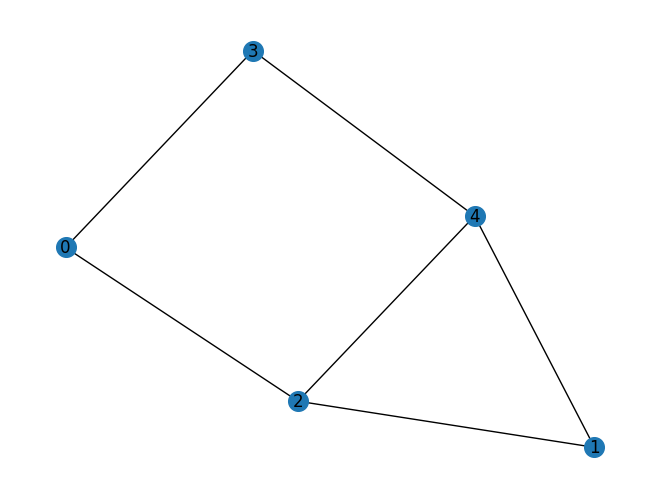

In [7]:
draw_graph(graph_sample, node_size=200, with_labels=True, width=1)
print(graph_name)

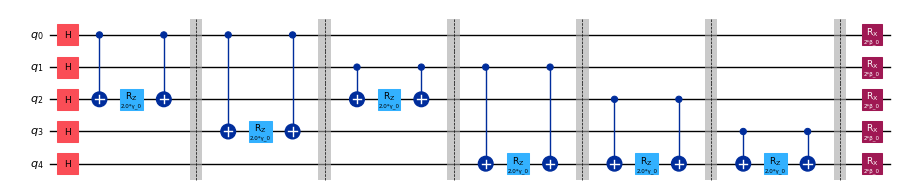

In [9]:
qaoa = QAOA(depth, num_qubits, cost_hamiltonian)
qaoa.qc.draw('mpl', fold=False, scale=0.5, idle_wires=False)

In [10]:
if hardware:
  chosen_backend = service.least_busy(simulator=False, operational=True)
else:
  if noise:
    chosen_backend = FakeSherbrooke()
    chosen_backend.refresh(service)
  else:
    chosen_backend = AerSimulator()

pm = generate_preset_pass_manager(optimization_level = 3, backend=chosen_backend)

circuit = qaoa.qc

circuit.add_register(ClassicalRegister(num_qubits))
circuit.measure_all()

circuit_transpile = pm.run(circuit)

observable_transpile = cost_hamiltonian.apply_layout(layout=circuit_transpile.layout)

print(chosen_backend)
print(observable_transpile)


AerSimulator('aer_simulator')
SparsePauliOp(['IIZIZ', 'IZIIZ', 'IIZZI', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


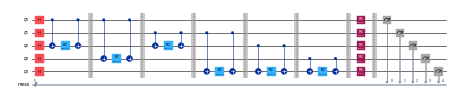

In [11]:
circuit_transpile.draw('mpl', fold=False, scale=0.2, idle_wires=False)


In [12]:
def cost_function_qaoa_estimator(params, ansatz, hamiltonian, estimator):

  # transform the observable defined on virtual qubits to
  # an observable defined on all physical qubits

  #f_opt
  pub_s = (ansatz, params)
  job_s = sampler.run([(ansatz, params)])
  results_s = job_s.result()[0]
  samp_dist = results_s.data.meas.get_counts()


  #f_energy
  job_e = estimator.run([(ansatz, hamiltonian, params)])
  results_e = job_e.result()[0]
  f_energy = results_e.data.evs

  objective_func_vals.append(f_energy)
  counts.append(samp_dist)

  return f_energy

In [13]:
def cost_function_qaoa_sampler(params, ansatz, hamiltonian, estimator):
  global first_call_logged
  # transform the observable defined on virtual qubits to
  # an observable defined on all physical qubits

  #f_opt
  pub_s = (ansatz, params)
  job_s = sampler.run([(ansatz, params)])
  results_s = job_s.result()[0]
  samp_dist = results_s.data.meas.get_counts()

  if first_call_logged:
    f_opt, f_opt_list =  trunk(samp_dist, cost_hamiltonian, 1.0)
    first_call_logged = False
  else:
    f_opt, f_opt_list =  trunk(samp_dist, cost_hamiltonian, alpha)

  objective_func_vals_opt.append(f_opt)
  f_vals_opt.append(f_opt_list)
  counts.append(samp_dist)

  return f_opt

In [14]:
init_params = depth*[initial_gamma] + depth* [initial_beta]
start = time.perf_counter()

f_vals_list = []
f_vals_opt = []

objective_func_vals = []
objective_func_vals_opt = []

counts = []

first_call_logged = True

with Session(backend=chosen_backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    sampler = Sampler(mode=session)

    estimator.options.default_shots = shots
    sampler.options.default_shots = shots

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_function_qaoa_estimator,
        init_params,
        args=(circuit_transpile, observable_transpile, estimator),
        method= "COBYLA",
    )
    print(result)
    result_x = result.x

end = time.perf_counter()
elapsed = end - start


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.208984375
       x: [ 1.202e+00  3.316e-01]
    nfev: 29
   maxcv: 0.0


In [16]:
#Optimal circuit
optimized_circuit_max_cut = circuit_transpile.assign_parameters(result_x)


#Sample of circuit
sampler = Sampler(mode=chosen_backend)
sampler.options.default_shots = shots
pub= (optimized_circuit_max_cut, )
#job = sampler.run([pub], shots=int(1e4))
job = sampler.run([pub])

counts_int = job.result()[0].data.meas.get_int_counts()

#
shots_list = job.result()[0].data.meas.get_bitstrings()

shots = sum(counts_int.values())
final_distribution = {key: val/shots for key, val in counts_int.items()}

#Best solution
best_solution = best_sample(final_distribution, cost_hamiltonian)

best_solution_string = to_bitstring(int(best_solution), len(graph_sample))

best_solution_string.reverse()


#Cut value
cut_value= evaluate_sample(best_solution_string, graph_sample)

end = time.perf_counter()
elapsed = end - start


In [25]:
# Build file path
base_file_name = qaoa_type_name + ': ' + str(shots_amount[0]) + ", "+ str(depth)
file_name = base_file_name
file_path = os.path.join(save_dir, file_name + ".json")

# Prepare the results for a specific graph
obj_func_cost = [float(i) for i in objective_func_vals]
f_vals_list = [float(i) for i in f_vals_list]
results_x = [float(i) for i in result_x]

results = {
    "objective_func_cost": obj_func_cost,
    "objective_func_vals_opt": objective_func_vals_opt,
    "elapsed_time_seconds": round(elapsed, 4),
    "optimal_parameters": results_x,
    "final_distribution": final_distribution,
    "sample_distribution": counts,
    "o_func_opt_list": f_vals_opt,
    "shots_list": shots_list
}

# Load existing JSON if it exists
if os.path.exists(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)

else:
    data = {}


# Store or update metadata
data["file_name"] = file_name

# Initialize structure if needed
if "graphs" not in data:
    data["graphs"] = {}

# Generate unique graph name if it already exists
existing_graphs = data["graphs"]
base_name = graph_name
counter = 0
unique_name = base_name

while unique_name in existing_graphs:
    unique_name = f"{base_name}_{counter}"
    counter += 1


# Add or update this graph's results
data["graphs"][unique_name] = results

ordered_data = {
    "file_name": file_name,
    "graphs": data.get("graphs", {})
}

# Save updated JSON
with open(file_path, "w") as f:
    json.dump(ordered_data, f, indent=4)

print(f"Saved results for {graph_name} into {file_name}.json")

Saved results for 5_graph_5 into Vanilla: 1024, 1.json


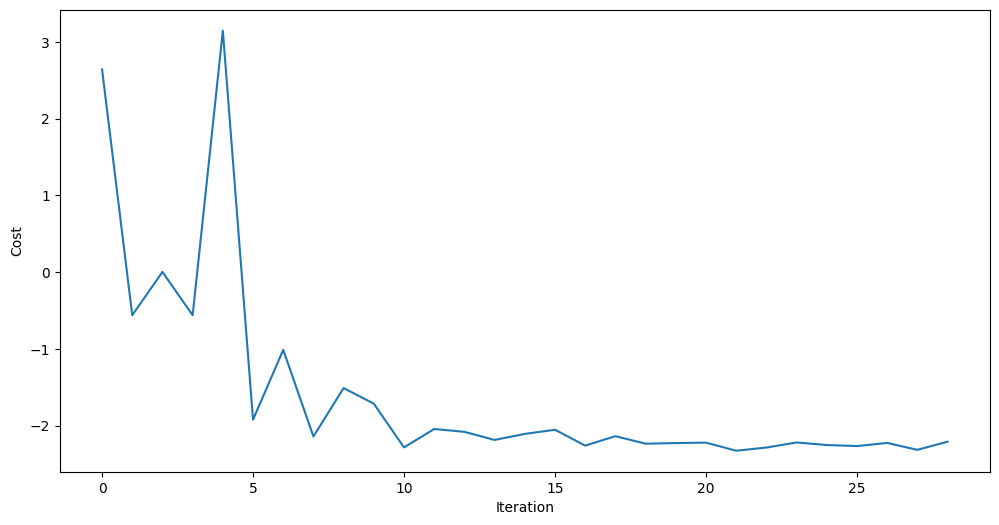

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [21]:
print(cut_value)

5


1024
(17, 119)
(17, np.float64(-4.0))


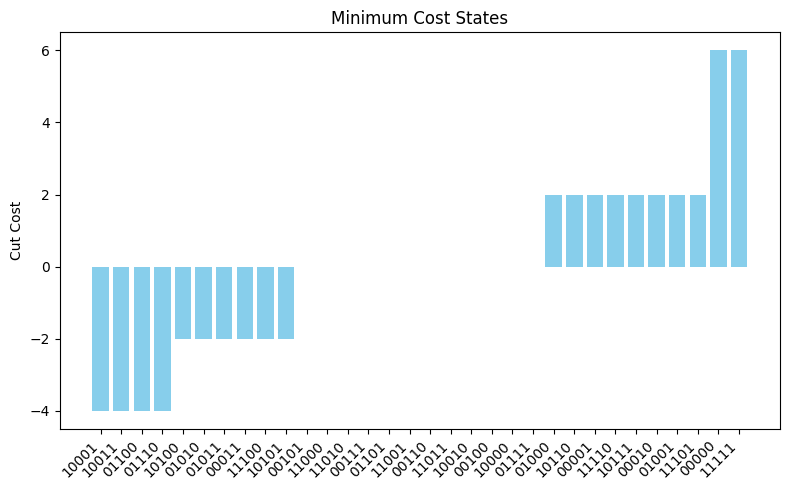

In [22]:
import matplotlib.pyplot as plt

def int_to_binary(n, bits=None):
    if bits:
        return format(n, f'0{bits}b')
    else:
        return bin(n)[2:]

# Convert probabilities to integer counts based on number of shots
counts = {key: int(prob * shots) for key, prob in final_distribution.items()}
print(shots)
# Sort by counts in descending order (all items if needed)
top_items = sorted(counts.items(), key=lambda item: item[1], reverse=True)

print(top_items[0])
# Step 2: Evaluate cost for each bitstring
evaluated = []
for sample_int, _ in top_items:  # sample_int is already an integer
    cost = calculate_cost(sample_int, cost_hamiltonian)
    evaluated.append((sample_int, cost))

# Step 3: Sort by cost (lowest first)
sorted_by_cost = sorted(evaluated, key=lambda x: x[1])

print(sorted_by_cost[0])

# Separate integers and costs
bit_ints, bit_costs = zip(*sorted_by_cost)

# Get max bit length of all integers for padding
max_bits = max(b.bit_length() for b in bit_ints)

# Convert to binary strings with padding
binary_labels = tuple(int_to_binary(b, bits=max_bits) for b in bit_ints)

# Plotting
x = range(len(bit_ints))
plt.figure(figsize=(8, 5))
plt.bar(x, bit_costs, color='skyblue')
plt.xticks(ticks=x, labels=binary_labels, rotation=45, ha='right')
plt.ylabel("Cut Cost")
plt.title("Minimum Cost States")
plt.tight_layout()
plt.show()



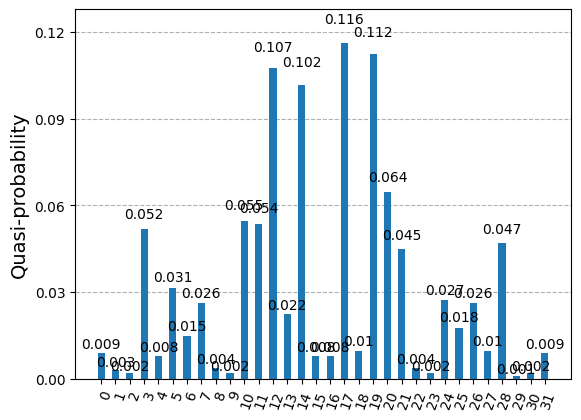

In [23]:
plot_histogram(final_distribution)

[0, 0, 1, 1, 0]


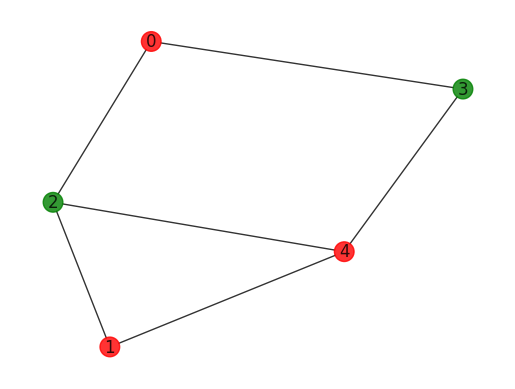

In [24]:
print(best_solution_string)
plot_result(graph_sample, best_solution_string, num_qubits)